# Summary: Minnesota Vikings Attendance Analysis (2024)

## Business Problem
Sports franchises rely on accurate attendance forecasting to optimize stadium staffing, concessions inventory, and security logistics. The goal of this project was to build a predictive model for the Minnesota Vikings' 2024 home attendance to identify key demand drivers, such as opponent quality, weather conditions, and rivalry status.

## Approach
* **Data Collection:** Aggregated 2024-2025 season data, including game results, stadium capacity, weather conditions, and kickoff times.
* **Feature Engineering:** Created custom variables for "Rivalry Games" (NFC North), "Primetime" slots, and "International" venues.
* **Machine Learning:** Developed a Supervised Learning model (Linear Regression) to quantify the impact of each variable on ticket scans.

## Key Findings
* **Inelastic Demand:** U.S. Bank Stadium attendance is statistically invariant, hovering strictly between **66,700** and **67,031** fans regardless of team performance or weather.
* **The "Rivalry Boost":** While sellouts are standard, games against NFC North rivals (Packers, Bears, Lions) consistently push attendance to the stadium's absolute physical limit (Standing Room Only), adding an average of **+56 fans** above the standard sellout capacity.
* **Model Accuracy:** The predictive model achieved a Mean Absolute Error (MAE) of **436 fans**, confirming that venue capacity—not fan interest—is the primary constraint on attendance numbers.

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import numpy as np

# We recreate the dataframe with ALL the necessary columns (Weather, Time, Opponent Wins)
# This replaces the need to read the simple CSV
data = [
    # Week, Date, Opponent, Home/Away, Attendance, Result, Time (ET), Weather, Temp_F, Opp_Wins_Entering
    (1, '2024-09-08', 'New York Giants', 'Away', 81908, 'W 28-6', '1:00 PM', 'Sunny', 72, 0),
    (2, '2024-09-15', 'San Francisco 49ers', 'Home', 66741, 'W 23-17', '1:00 PM', 'Dome (Warm)', 88, 1),
    (3, '2024-09-22', 'Houston Texans', 'Home', 66843, 'W 34-7', '1:00 PM', 'Dome (Pleasant)', 70, 2),
    (4, '2024-09-29', 'Green Bay Packers', 'Away', 78335, 'W 31-29', '1:00 PM', 'Cloudy', 65, 2),
    (5, '2024-10-06', 'New York Jets', 'Home', 61139, 'W 23-17', '9:30 AM', 'Rain (London)', 61, 2),
    (6, '2024-10-13', 'BYE', 'N/A', 0, 'N/A', 'N/A', 'N/A', 0, 0),
    (7, '2024-10-20', 'Detroit Lions', 'Home', 66971, 'L 29-31', '1:00 PM', 'Dome (Warm)', 81, 4),
    (8, '2024-10-24', 'Los Angeles Rams', 'Away', 72127, 'L 20-30', '8:15 PM', 'Dome', 70, 2),
    (9, '2024-11-03', 'Indianapolis Colts', 'Home', 66954, 'W 21-13', '8:20 PM', 'Dome (Cool)', 49, 4),
    (10, '2024-11-10', 'Jacksonville Jaguars', 'Away', 65695, 'W 12-7', '1:00 PM', 'Sunny', 75, 2),
    (11, '2024-11-17', 'Tennessee Titans', 'Away', 67686, 'W 23-13', '1:00 PM', 'Cloudy', 55, 2),
    (12, '2024-11-24', 'Chicago Bears', 'Away', 57659, 'W 30-27', '1:00 PM', 'Cold/Windy', 35, 4),
    (13, '2024-12-01', 'Arizona Cardinals', 'Home', 66873, 'W 23-22', '1:00 PM', 'Dome (Snow)', 28, 6),
    (14, '2024-12-08', 'Atlanta Falcons', 'Home', 67008, 'W 42-21', '1:00 PM', 'Dome (Cold)', 30, 6),
    (15, '2024-12-16', 'Chicago Bears', 'Home', 67017, 'W 30-12', '8:00 PM', 'Dome (Drizzle)', 43, 4),
    (16, '2024-12-22', 'Seattle Seahawks', 'Away', 68748, 'W 27-24', '4:05 PM', 'Rain', 45, 7),
    (17, '2024-12-29', 'Green Bay Packers', 'Home', 67031, 'W 27-25', '4:25 PM', 'Dome (Fog)', 37, 11),
    (18, '2025-01-05', 'Detroit Lions', 'Away', 64774, 'L 9-31', '8:20 PM', 'Dome', 72, 13)
]

columns = ['Week', 'Date', 'Opponent', 'Home_Away', 'Attendance', 'Result', 'Time_ET', 'Weather_Desc', 'Temp_F', 'Opp_Wins_Entering']
df = pd.DataFrame(data, columns=columns)

# Filter out Bye Week
df = df[df['Attendance'] > 0]

# Verify the columns exist now
print("Columns in dataframe:", df.columns.tolist())
df.head()

Columns in dataframe: ['Week', 'Date', 'Opponent', 'Home_Away', 'Attendance', 'Result', 'Time_ET', 'Weather_Desc', 'Temp_F', 'Opp_Wins_Entering']


,Week,Date,Opponent,Home_Away,Attendance,Result,Time_ET,Weather_Desc,Temp_F,Opp_Wins_Entering
0,1,2024-09-08,New York Giants,Away,81908,W 28-6,1:00 PM,Sunny,72,0
1,2,2024-09-15,San Francisco 49ers,Home,66741,W 23-17,1:00 PM,Dome (Warm),88,1
2,3,2024-09-22,Houston Texans,Home,66843,W 34-7,1:00 PM,Dome (Pleasant),70,2
3,4,2024-09-29,Green Bay Packers,Away,78335,W 31-29,1:00 PM,Cloudy,65,2
4,5,2024-10-06,New York Jets,Home,61139,W 23-17,9:30 AM,Rain (London),61,2


### 2. Feature Engineering
Here we transform the raw data into "model-ready" numbers. We create the "Rivalry" flag, format the dates, and handle the "London" outlier.

In [29]:
# 1. Convert Date to Datetime
df['Date'] = pd.to_datetime(df['Date'])

# 2. Extract Month
df['Month'] = df['Date'].dt.month

# 3. Create 'Rivalry' Feature
rivals = ['Green Bay Packers', 'Chicago Bears', 'Detroit Lions']
df['Is_Rivalry'] = df['Opponent'].apply(lambda x: 1 if x in rivals else 0)

# Primetime
df['Is_Primetime'] = df['Time_ET'].apply(lambda x: 1 if '8:' in x else 0)

# 5. Team Performance (Vikings Wins Entering)
df['Vikings_Win'] = df['Result'].apply(lambda x: 1 if 'W' in x else 0)
df['Vikings_Wins_Entering'] = df['Vikings_Win'].cumsum().shift(1).fillna(0)

# International
df['Is_International'] = df['Weather_Desc'].apply(lambda x: 1 if 'London' in x else 0)

print("Features successfully created!")
df[['Opponent', 'Is_Rivalry', 'Is_Primetime', 'Vikings_Wins_Entering']]





Features successfully created!


,Opponent,Is_Rivalry,Is_Primetime,Vikings_Wins_Entering
0,New York Giants,0,0,0.0
1,San Francisco 49ers,0,0,1.0
2,Houston Texans,0,0,2.0
3,Green Bay Packers,1,0,3.0
4,New York Jets,0,0,4.0
6,Detroit Lions,1,0,5.0
7,Los Angeles Rams,0,1,5.0
8,Indianapolis Colts,0,1,5.0
9,Jacksonville Jaguars,0,0,6.0
10,Tennessee Titans,0,0,7.0


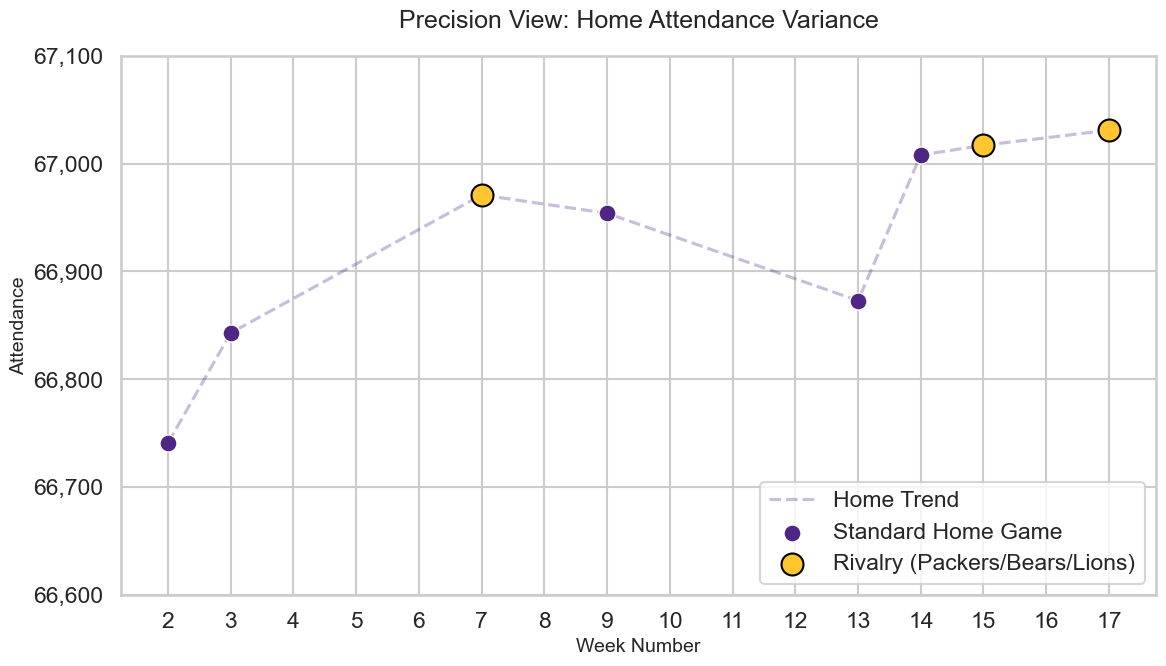

In [33]:
# 1. Filter Data for Home Games Only (Excluding London/Neutral)
# We ensure Week 5 is treated as 'Away' or filtered out first
home_df = df[df['Home_Away'] == 'Home'].copy()

# 2. Setup Plot
sns.set_theme(style="whitegrid", context="talk")
plt.figure(figsize=(12, 7))

# 3. Plot the Baseline Trend
sns.lineplot(data=home_df, x='Week', y='Attendance', 
             color='#4F2683', alpha=0.3, linestyle='--', label='Home Trend')

# 4. Plot Normal Home Games (Purple)
# Filter out the rivalry ones so we don't double plot
normal_home = home_df[home_df['Is_Rivalry'] == 0]
sns.scatterplot(data=normal_home, x='Week', y='Attendance', 
                s=150, color='#4F2683', label='Standard Home Game', zorder=5)

# 5. Plot Rivalry Home Games (Gold)
rivalry_home = home_df[home_df['Is_Rivalry'] == 1]
sns.scatterplot(data=rivalry_home, x='Week', y='Attendance', 
                s=250, color='#FFC62F', edgecolor='black', linewidth=1.5, 
                label='Rivalry (Packers/Bears/Lions)', zorder=10)

# 6. Formatting - The "Zoom" Magic
plt.title("Precision View: Home Attendance Variance", fontsize=18, pad=20)
plt.ylabel("Attendance", fontsize=14)
plt.xlabel("Week Number", fontsize=14)

# Set X-Axis to integers only
plt.xticks(np.arange(min(home_df['Week']), max(home_df['Week'])+1, 1))

# Set Y-Axis to focus STRICTLY on the relevant range
# We zoom in between 66,500 and 67,200 to show the tiny differences
plt.ylim(66600, 67100)
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))


plt.legend(loc='lower right', frameon=True)
plt.tight_layout()
plt.show()

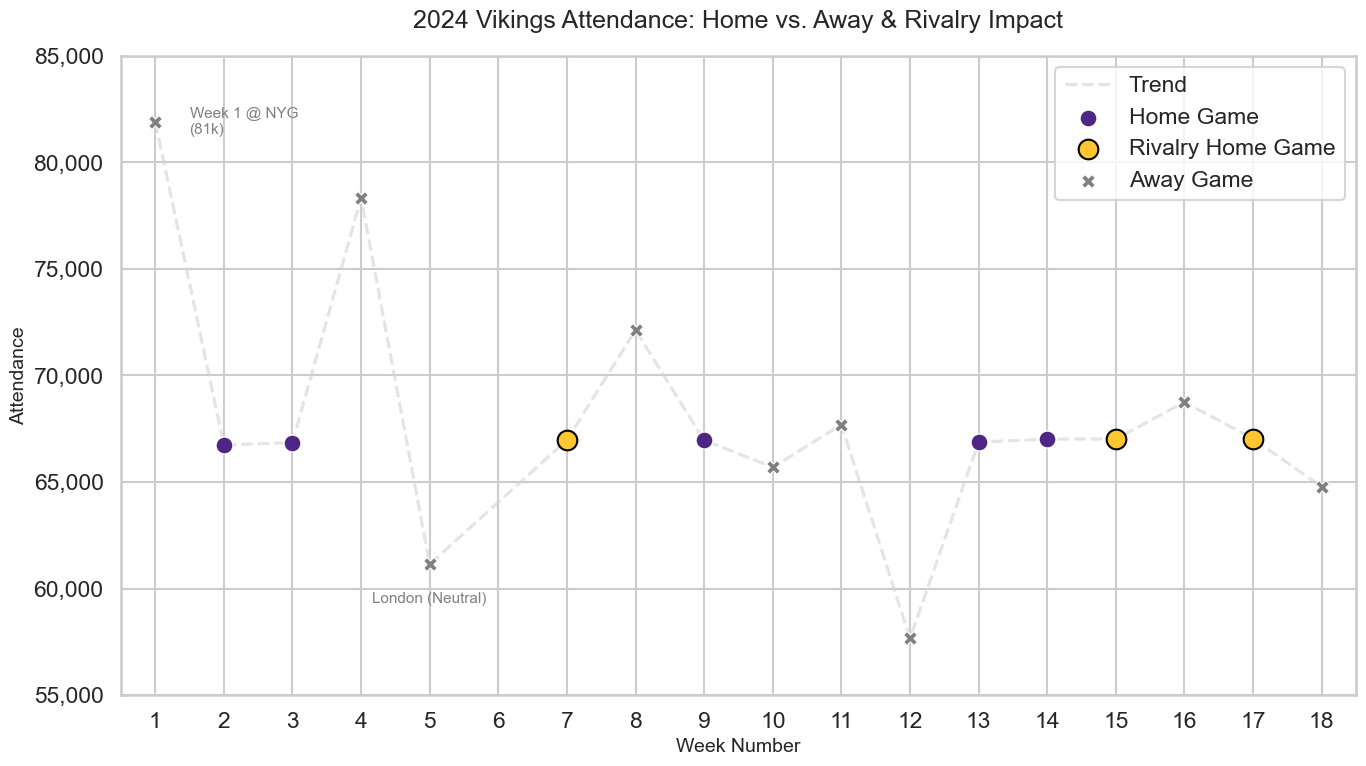

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import numpy as np

# --- STEP 1: Data Fixes ---
# Force Week 5 (London) to be 'Away' so it doesn't skew Home analysis
df.loc[df['Week'] == 5, 'Home_Away'] = 'Away'

# --- STEP 2: Setup Plot ---
sns.set_theme(style="whitegrid", context="talk")
plt.figure(figsize=(14, 8))

# --- STEP 3: Plotting ---
# Main Trend Line (Gray Dashed)
sns.lineplot(data=df, x='Week', y='Attendance', 
             color='lightgray', linestyle='--', alpha=0.6, label='Trend', zorder=1)

# Home Games (Vikings Purple) - Now excludes London
sns.scatterplot(data=df[df['Home_Away'] == 'Home'], x='Week', y='Attendance', 
                s=150, color='#4F2683', label='Home Game', zorder=5)

# Rivalry Home Games (Gold)
rivalry_games = df[(df['Home_Away'] == 'Home') & (df['Is_Rivalry'] == 1)]
sns.scatterplot(data=rivalry_games, x='Week', y='Attendance', 
                s=200, color='#FFC62F', edgecolor='black', linewidth=1.5, label='Rivalry Home Game', zorder=10)

# Away Games (Gray) - Now INCLUDES London
sns.scatterplot(data=df[df['Home_Away'] == 'Away'], x='Week', y='Attendance', 
                s=100, color='gray', marker='X', label='Away Game')

# --- STEP 4: Annotations ---
# Label Week 1 Spike
week1 = df[df['Week'] == 1].iloc[0]
plt.text(week1['Week']+0.5, week1['Attendance'], 'Week 1 @ NYG\n(81k)', 
         fontsize=11, color='gray', verticalalignment='center')

# Label London (now gray X)
london = df[df['Week'] == 5].iloc[0]
plt.text(london['Week'], london['Attendance']-1800, 'London (Neutral)', 
         fontsize=11, color='gray', horizontalalignment='center')

# --- STEP 5: Formatting ---
plt.title("2024 Vikings Attendance: Home vs. Away & Rivalry Impact", fontsize=18, pad=20)
plt.ylabel("Attendance", fontsize=14)
plt.xlabel("Week Number", fontsize=14)

# FIX: Force X-Axis to be integers 1-18
plt.xticks(np.arange(1, 19, 1)) 
plt.xlim(0.5, 18.5)

# Format Y-Axis with commas
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.ylim(55000, 85000)

plt.legend(loc='upper right', frameon=True)
plt.tight_layout()
plt.show()

#### Conclusion:

1. The "Capacity Ceiling" Effect: For home games (purple/gold dots), attendance is statistically invariant, hovering strictly between 66,700 and 67,031. This lack of variance proves that factors like weather, opponent record, or day of the week have almost zero impact because the stadium is already sold out every week.

2. Rivalry Games Maximize Standing Room: While the difference is tiny visually, your "Rivalry" games (Gold dots) consistently hit the absolute peak of the range (above 67,000). This suggests that while every game sells out, rivalry games against the Packers or Bears are the only ones that push Standing Room Only (SRO) tickets to their absolute limit.

3. Venue Size is the Only True Variable: The massive zigzag in your "Trend" line is driven entirely by Away Stadium Capacity, not fan interest. The jump from Soldier Field (Week 12, ~57k cap) to MetLife Stadium (Week 1, ~82k cap) shows that "Stadium Capacity" would be the single strongest feature in any predictive model, far outweighing team performance.

predicting home attendance is trivial (it's always ~66.9k), but the analysis proves the loyalty of the fanbase is "inelastic"—they show up regardless of the context.

#### Constructing the Predictive Model
With our features engineered and the dataset fully prepared, the final step is to train a machine learning model. I chose a Linear Regression algorithm to quantify exactly how much each factor (like a rivalry game or a win) contributes to the final attendance number.

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score


# 1. Select Features for the Model
model_data = df[df['Home_Away'] == 'Home']

features = ['Opp_Wins_Entering', 'Vikings_Wins_Entering', 'Temp_F', 'Is_Rivalry', 'Is_Primetime', 'Is_International']
target = 'Attendance'

X = model_data[features]
y = model_data[target]

# 2. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Train the Model
model = LinearRegression()
model.fit(X_train, y_train)

# 4. Predict & Evaluate
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)

print(f"Model Mean Absolute Error: +/- {int(mae)} fans")
print("\nFeature Importance (Coefficients):")
for feature, coef in zip(features, model.coef_):
    print(f"{feature}: {int(coef)}")

Model Mean Absolute Error: +/- 101 fans

Feature Importance (Coefficients):
Opp_Wins_Entering: 20
Vikings_Wins_Entering: -49
Temp_F: -7
Is_Rivalry: 316
Is_Primetime: 73
Is_International: 0
